In [1]:
from PIL import Image, ImageDraw, ImageFilter
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Convolution2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout
from tensorflow.keras import optimizers
from tqdm import tqdm
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (8,6)


### Generate data

In [4]:
size=300

In [5]:
path = "white_hand/"
file_list = os.listdir(path)
number_of_images = int(len(file_list) / 2)

image_list = []
value_list = []

np.random.seed(1)                            
                                             
all_image_array = np.arange(number_of_images)
np.random.shuffle(all_image_array)           
                                             

for i in all_image_array:
    image_list += [np.load(path + "image_" + str(i) + ".npy")]
    value_list += [np.load(path + "values_" + str(i) + ".npy")]

# SPLIT THE DATA

split = 900

image_list_training = image_list[:split]
image_list_test = image_list[split:]

value_list_training = value_list[:split]
value_list_test = value_list[split:]

image_training_array = np.asarray(image_list_training)
image_test_array = np.asarray(image_list_test)

value_training_array = np.asarray(value_list_training)
value_test_array = np.asarray(value_list_test)

In [7]:
def plot(X,Y):
    plt.imshow(X)
    padding=0
    plt.scatter([Y[0],Y[1],Y[0],Y[1]],\
                [Y[2],Y[3],Y[3],Y[2]],c='red')
    ax = plt.gca()
    ax.add_patch(patches.Rectangle((Y[0],Y[2]),Y[1]-Y[0],Y[3]-Y[2],linewidth=2,edgecolor='r',facecolor='none'))
    return plt

In [10]:
print(np.shape(image_test_array)[0])
samples=np.shape(image_training_array)[0]+np.shape(image_test_array)[0]
test_samples=np.shape(image_test_array)[0]
print(samples)
print(np.shape(image_training_array)[0])

275
7475
(7200, 300, 300, 3)


[ 88.       166.890625  81.       126.421875]


<module 'matplotlib.pyplot' from 'D:\\Programme\\Anaconda\\Lib\\site-packages\\matplotlib\\pyplot.py'>

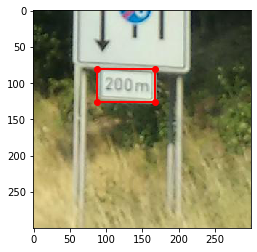

In [9]:
print(value_training_array[0])
plot(image_training_array[0],value_training_array[0])

## Preprocessing

#### Histogram stretching

for i in range(samples-test_samples):
    img_yuv = cv2.cvtColor(image_training_array[i], cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    image_training_array[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
for i in range(test_samples):
    img_yuv = cv2.cvtColor(image_test_array[i], cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    image_test_array[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

#### Histograms

In [7]:
row_train=np.zeros((samples-test_samples, size, 3, 1))
for i in range(samples-test_samples):
    for j in range(size):
        for c in range(3):
            row_train[i,j,c]=np.sum(image_training_array[i,j,:,c])
            
row_test=np.zeros((test_samples, size, 3, 1))
for i in range(test_samples):
    for j in range(size):
        for c in range(3):
            row_train[i,j,c]=np.sum(image_test_array[i,j,:,c])


            
col_train=np.zeros((samples-test_samples, size, 3, 1))
for i in range(samples-test_samples):
    for j in range(size):
        for c in range(3):
            col_train[i,j,c]=np.sum(image_training_array[i,:,j,c])
            
col_test=np.zeros((test_samples, size, 3, 1))
for i in range(test_samples):
    for j in range(size):
        for c in range(3):
            col_test[i,j,c]=np.sum(image_test_array[i,:,j,c])
            
            
print(row_train.shape)

(900, 300, 3, 1)


## Normalization

In [8]:
#x_train = x_train.reshape(x_train.shape[0], canvas_size[0], canvas_size[1],3)
#x_test = x_test.reshape(x_test.shape[0],  canvas_size[0], canvas_size[1],3)

#Normalization
image_training_array = image_training_array.astype('float32')/255
image_test_array = image_test_array.astype('float32')/255
value_training_array = value_training_array.astype('float32')/size
value_test_array = value_test_array.astype('float32')/size


#histogram
row_train = row_train.astype('float32')/(size*255)
row_test = row_test.astype('float32')/(size*255)
col_train = col_train.astype('float32')/(size*255)
col_test = col_test.astype('float32')/(size*255)

## Define and train model

In [9]:
img_input = keras.Input(shape=(size, size, 3), name="image")
row_input = keras.Input(shape=(size, 3, 1), name="row")
col_input = keras.Input(shape=(size, 3, 1), name="col")

x = layers.MaxPooling2D(pool_size=(2,2))(img_input)
x = layers.Convolution2D(20, (3,3),activation='relu')(x)
x = layers.Convolution2D(15, (3,3),activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Convolution2D(10, (3,3),activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x_flat = layers.Flatten()(x)
r = layers.Flatten()(row_input)
r = layers.Dense(300, activation = 'relu')(r)
r = layers.Dense(100, activation = 'relu')(r)
r_flat = layers.Flatten()(r)
c = layers.Flatten()(col_input)
c = layers.Dense(300, activation = 'relu')(c)
c = layers.Dense(100, activation = 'relu')(c)
c_flat = layers.Flatten()(c)

conc = layers.concatenate([x_flat, r_flat, c_flat])
#conc = layers.Dense(200, activation = 'relu')(conc)
pos_pred = layers.Dense(4, name="output")(conc)

model = keras.Model(inputs=[img_input, row_input, col_input], outputs=[pos_pred])

In [10]:
model.compile(optimizer='adam',loss='mse')


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 150, 150, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 148, 148, 20) 560         max_pooling2d[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 146, 146, 15) 2715        conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
history=model.fit(
    {"image": image_training_array, "row": row_train, "col": col_train},
    {"output": value_training_array},
    epochs=40, 
    batch_size=20, 
    validation_split=0.1, 
    shuffle=True, 
    verbose=2,
)

Epoch 1/40
41/41 - 18s - loss: 0.1350 - val_loss: 0.0318
Epoch 2/40
41/41 - 16s - loss: 0.0171 - val_loss: 0.0117
Epoch 3/40
41/41 - 17s - loss: 0.0074 - val_loss: 0.0066
Epoch 4/40
41/41 - 18s - loss: 0.0064 - val_loss: 0.0057
Epoch 5/40
41/41 - 16s - loss: 0.0058 - val_loss: 0.0055
Epoch 6/40
41/41 - 16s - loss: 0.0050 - val_loss: 0.0056
Epoch 7/40
41/41 - 18s - loss: 0.0048 - val_loss: 0.0057
Epoch 8/40
41/41 - 18s - loss: 0.0048 - val_loss: 0.0061
Epoch 9/40
41/41 - 17s - loss: 0.0047 - val_loss: 0.0051
Epoch 10/40
41/41 - 17s - loss: 0.0041 - val_loss: 0.0063
Epoch 11/40
41/41 - 17s - loss: 0.0038 - val_loss: 0.0056
Epoch 12/40
41/41 - 17s - loss: 0.0039 - val_loss: 0.0057
Epoch 13/40
41/41 - 17s - loss: 0.0033 - val_loss: 0.0056
Epoch 14/40
41/41 - 18s - loss: 0.0032 - val_loss: 0.0053
Epoch 15/40
41/41 - 16s - loss: 0.0030 - val_loss: 0.0058
Epoch 16/40
41/41 - 17s - loss: 0.0028 - val_loss: 0.0053
Epoch 17/40
41/41 - 16s - loss: 0.0027 - val_loss: 0.0068
Epoch 18/40
41/41 - 16s

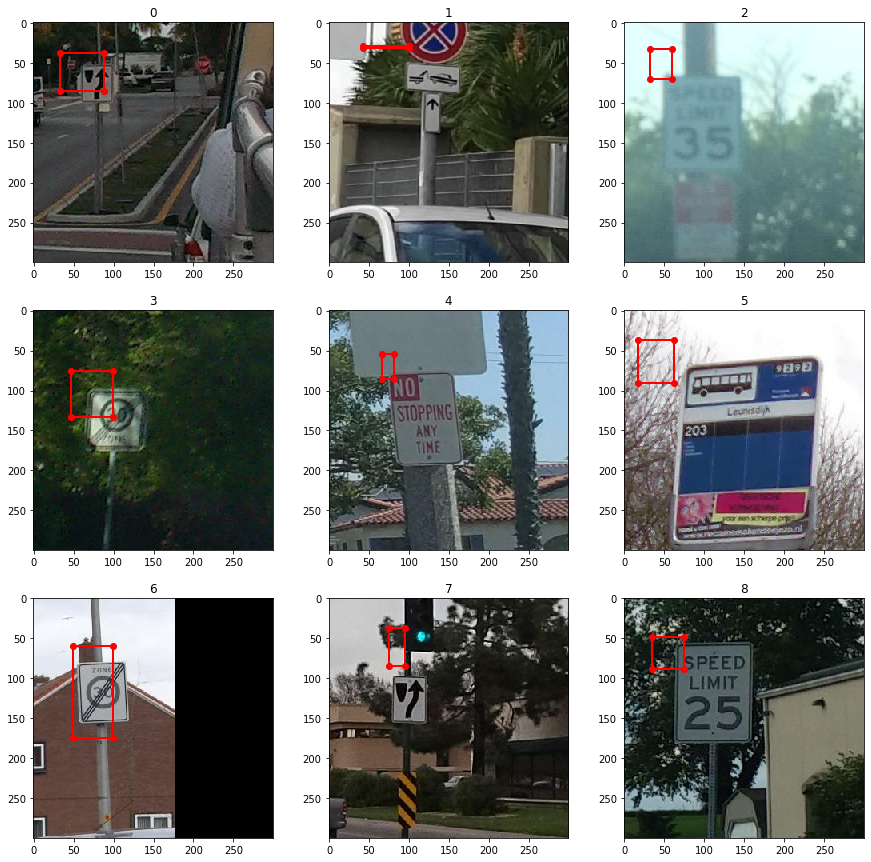

In [15]:
plt.figure(figsize=(15,15))
for i in range(9):
    ax= plt.subplot(3,3,i+1)
    k = random.randint(0,len(image_test_array))-1
    x=image_test_array[k]
    r=row_test[k]
    c=col_test[k]
    #x=image_test_array[i]
    #r=row_test[i]
    #c=col_test[i]
    #r=np.zeros((size, 3, 1))
    #c=np.zeros((size, 3, 1))
    y=model.predict({"image": np.array([x]), "row": np.array([r]), "col": np.array([c])})[0]
    im=plot(x,y*size)
    plt.title(i)

In [ ]:
model.save('./model_white_hand.weights')

In [ ]:
model = keras.models.load_model('./model.weights')